# Install Docker

Check the website for further setup

# Understanding data persistence

When we create a container from a container image, everything in the image is treated as read-only, and there is a new layer overlayed on top that is read/write.

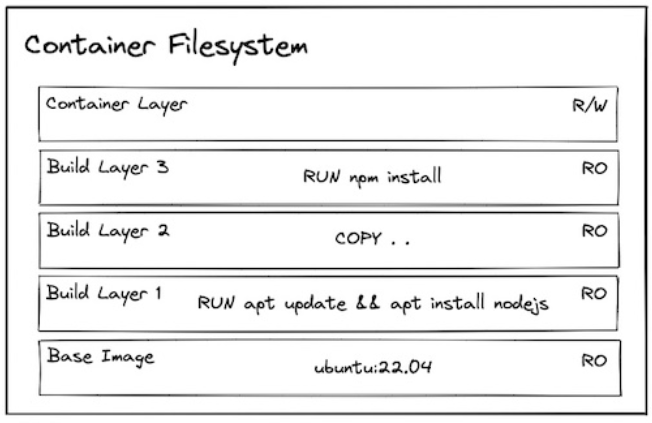

### A. Installing Dependencies:

Let's experiment with how installing something into a container at runtime behaves!

**Note**: Modifying the contents of a container at runtime is not something you would normally do. We are doing it here for instructional purposes only!

```python
# Create a container from the ubuntu image
docker run --interactive --tty --rm ubuntu:22.04

# Try to ping google.com
ping google.com -c 1 # This results in `bash: ping: command not found`

# Install ping
apt update
apt install iputils-ping --yes

ping google.com -c 1 # This time it succeeds!
exit
```

Let's try that again:

```python
docker run -it --rm ubuntu:22.04
ping google.com -c 1 # It fails!
```

It fails the second time because we installed it into that read/write layer specific to the first container, and when we tried again it was a separate container with a separate read/write layer!

We can give the container a name so that we can tell docker to reuse it:

```python
# Create a container from the ubuntu image (with a name and WITHOUT the --rm flag)
docker run -it --name my-ubuntu-container ubuntu:22.04

# Install & use ping
apt update
apt install iputils-ping --yes
ping google.com -c 1
exit

# List all containers
docker container ps -a | grep my-ubuntu-container
docker container inspect my-ubuntu-container

# Restart the container and attach to running shell
docker start my-ubuntu-container
docker attach my-ubuntu-container

# Test ping
ping google.com -c 1 # It should now succeed! 🎉
exit
```

We generally never want to rely on a container to persist the data, so for a dependency like this, we would want to include it in the image:

```python
# Build a container image with ubuntu image as base and ping installed
docker build --tag my-ubuntu-image -<<EOF
FROM ubuntu:22.04
RUN apt update && apt install iputils-ping --yes
EOF

# Run a container based on that image
docker run -it --rm my-ubuntu-image

# Confirm that ping was pre-installed
ping google.com -c 1 # Success! 🥳
```

The `FROM... RUN...` stuff is part of what is called a `Dockerfile` that is used to specify how to build a container image. We will go much deeper into building containers later in the course, but for now just understand that for anything we need in the container at runtime we should build it into the image!

The one exception to this rule is environment specific configuration (environment variables, config files, etc...) which can be provided at runtime as a part of the environment (see: https://12factor.net/config).

### B. Persisting Data Produced by the Application:

Often, our applications produce data that we need to safely persist (e.g. database data, user uploaded data, etc...) even if the containers are destroyed and recreated. Luckily, Docker (and containers more generally) have a feature to handle this use case called `Volumes` and `mounts`!

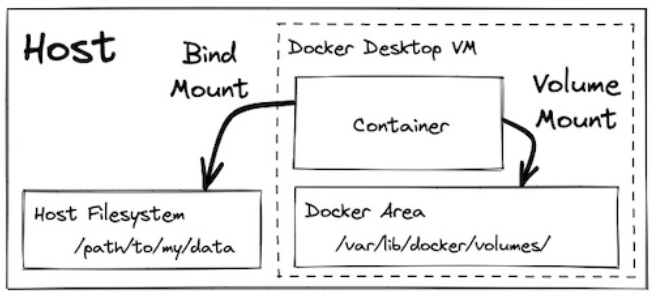

`Volumes` and `mounts` allow us to specify a location where data should persist beyond the lifecycle of a single container. The data can live in a location managed by Docker (`volume mount`), a location in your host filesystem (`bind mount`), or in memory (`tmpfs mount`, not pictured).

***NOTE***: *This third option (`tmpfs mount`) does not persist the data after the container exits, and is instead used as a temporary store for data you specifically DON'T want to persist (for example credential files). It is included here for completeness but should not be used for application data you want to persist.*

Let's experiment with how creating some data within a container at runtime behaves!

```python
# Create a container from the ubuntu image
docker run -it --rm ubuntu:22.04

# Make a directory and store a file in it
mkdir my-data
echo "Hello from the container!" > /my-data/hello.txt

# Confirm the file exists
cat my-data/hello.txt
exit
```

If we then create a new container, (as expected) the file does not exist!

```python
# Create a container from the ubuntu image
docker run -it --rm ubuntu:22.04

# Check if the file exists
cat my-data/hello.txt # Produces error: `cat: my-data/hello.txt: No such file or directory`
```

##### Volume Mounts

We can use volumes and mounts to safely persist the data.

```python
# create a named volume
docker volume create my-volume

# Create a container and mount the volume into the container filesystem
docker run  -it --rm --mount source=my-volume,destination=/my-data/ ubuntu:22.04
# There is a similar (but shorter) syntax using -v which accomplishes the same
docker run  -it --rm -v my-volume:/my-data ubuntu:22.04

# Now we can create and store the file into the location we mounted the volume
echo "Hello from the container!" > /my-data/hello.txt
cat my-data/hello.txt
exit
```

We can now create a new container and mount the existing volume to confirm the file persisted:

```python
# Create a new container and mount the volume into the container filesystem
docker run  -it --rm --mount source=my-volume,destination=/my-data/ ubuntu:22.04
cat my-data/hello.txt # This time it succeeds! 
exit
```

Where is this data located? On linux it would be at `/var/lib/docker/volumes...` but remember, on docker desktop, Docker runs a linux virtual machine.

One way we can view the filesystem of that VM is to use a container image created by **justincormat** that allows us to create a container within the namespace of PID 1. This effectively gives us a container with root access in that VM.

***NOTE***: *Generally you should be careful running containers in privileged mode with access to the host system in this way. Only do it if you have a specific reason to do so and you trust the container image.*

```python
# Create a container that can access the Docker Linux VM
# Pinning to the image hash ensures it is this SPECIFIC image and not an updated one helps minimize the potential of a supply chain attack
docker run -it --rm --privileged --pid=host justincormack/nsenter1@sha256:5af0be5e42ebd55eea2c593e4622f810065c3f45bb805eaacf43f08f3d06ffd8

# Navigate to the volume inside the VM at:
ls /var/lib/docker/volumes/my-volume/_data
cat /var/lib/docker/volumes/my-volume/_data/hello.txt # Woohoo! we found our data!
```

This approach can then be used to mount a volume at the known path where a program persists its data:

```python
# Create a container from the postgres container image and mount its known storage path into a volume named pgdata
docker run -it --rm -v pgdata:/var/lib/postgresql/data -e POSTGRES_PASSWORD=foobarbaz postgres:15.1-alpine

##### Bind Mounts

Alternatively, we can mount a directory from the host system using a bind mount:

```python
# Create a container that mounts a directory from the host filesystem into the container
docker run  -it --rm --mount type=bind,source="${PWD}"/my-data,destination=/my-data ubuntu:22.04
# Again, there is a similar (but shorter) syntax using -v which accomplishes the same
docker run  -it --rm -v ${PWD}/my-data:/my-data ubuntu:22.04

echo "Hello from the container!" > /my-data/hello.txt

# You should also be able to see the hello.txt file on your host system
cat my-data/hello.txt
exit
```

Bind mounts can be nice if you want easy visibility into the data being stored, but there are a number of reasons outlined at https://docs.docker.com/storage/volumes/ (including speed if you are running Docker Desktop on windows/mac) for why volumes are preferred.

# Use Cases

Now that we have an understanding of how data storage works with containers we can start to explore various use cases for running 3rd party containers.

For me, the main categories are databases, interactive test environments, and CLI utilities.

### Databases

Databases are notoriously fickle to install and configure. The instructions are often complex and vary across different versions and operating systems. For development, where you might need to run multiple versions of a single database or create a fresh database for testing purposes running in a container can be a massive improvement.

The setup/installation is handled by the container image, and all you need to provide is some configuration values. Switching between versions of the database is as easy as specifying a different image tag (eg. `postgres:14.6` vs `postgres:15.1`)

A few key considerations when running databases in containers:
- **Use volume(s) to persist data**: The entire reason for section above was to give you an understanding of how to avoid data loss. Generally databases will store its data at one or more known paths. You should identify those and mount volumes to those locations in the containers to ensure data persists beyond the container.
- **Use bind mount(s) for additional config**: Often databases use configuration files to influence runtime behavior. You can create these files on your host system, and then use a bind mount to place them in the correct location within the container to be read upon startup.
- **Set environment variables**: In addition to configuration files many databases use environment variables to influence runtime behavior (for example setting the admin password). Identify these variables and set the accordingly.

# Core Command Group

## Interaction

### 1. `docker run` - run a Container

```py
docker run [FLAGS] IMAGE [COMMAND]
```

| Flag                | Meaning              |
| ------------------- | -------------------- |
| `--name`            | Name container       |
| `--rm`              | Remove when stop     |
| `-it`               | Interactive terminal |
| `-d`                | Background run       |
| `-p host:container` | Map port             |
| `-v host:container` | Mount volume         |
| `-e KEY=VALUE`      | Env variable         |
| `--network`         | Network              |
| `--restart`         | Restart policy       |
| `--gpus all`        | GPU                  |
| `--shm-size`        | Shared memory        |


### 2. `docker ps` - see Container

```py
docker ps [FLAG]
```

| Flag | Meaning                   |
| ---- | ------------------------- |
| `-a` | Included stop Container   |


### 3. `docker stop / start / restart / rm`

```py
docker stop app
docker start app
docker restart app
docker rm app
```

Container lifecycle management

### 4. `docker exec`

```python
docker exec -it app bash
```

| Flag | Meaning |
| ---- | ------- |
| `-i` | stdin   |
| `-t` | TTY     |


### 5. `docker logs`

```python
docker logs app
docker logs -f app
```

| Flag | Meaning             |
| ---- | ------------------- |
| `-f` | Follow log realtime |


## Image & Build

### 6. `docker images / pull / rmi`

```python
docker images
docker pull python:3.11-slim
docker rmi myimage
```

### 7. `docker build`

```
docker build -t myapp:1.0 .
```

| Flag          | Meaning           |
| ------------- | ----------------- |
| `-t`          | Tag image         |
| `--no-cache`  | Re-build          |
| `--build-arg` | Build var passing |


## Storage & Network

### 8. Volume

```python
docker volume ls
docker volume create data
docker volume rm data
```

Mount:

```python
-v data:/var/lib/data
-v $(pwd):/app
```

### 9. Network

```
docker network ls
docker network create mynet
docker network inspect mynet
```

Run Container:

```python
docker run --network mynet redis
```

## Debug & Monitor

### 10. `docker inspect`

```python
docker inspect app
```

Check all JSON config

### 11. `docker stats`

```python
docker stats
```

CPU / RAM in realtime

### 12. `docker top`

```python
docker top app
```

Process in Container

## Cleanup & Maintenance

### 13. `docker system`

```python
docker system df
docker system prune
docker system prune -a
```

| Lệnh    | Tác dụng           |
| ------- | ------------------ |
| `df`    | Check storage size |
| `prune` | Delete non-used    |
| `-a`    | Delete image       |


## 14. `docker compose`

```python
docker compose up
docker compose up -d
docker compose down
docker compose logs
docker compose ps
```

Use this when the number of flag > 5